In [29]:
#Python packages
import numpy as np
import pandas as pd
import re
from scipy import stats
import json

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#modeling packages
from collections import defaultdict
import lightgbm as lgb
import copy
import xgboost as xgb
import catboost as cat
from time import time
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
# from bayes_opt import BayesianOptimization
# import eli5
# import shap
# from IPython.display import HTML
from category_encoders.ordinal import OrdinalEncoder
import time
from numba import jit
import eli5
import shap
from IPython.display import HTML
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

import gc

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [3]:
# train = pd.read_csv('train.csv', index_col=0)
# spec = pd.read_csv('specs.csv', index_col=0)
# train_labels = pd.read_csv('train_labels.csv', index_col=0)
# test = pd.read_csv('test_fin.csv', index_col=0)
# new_train = pd.read_csv('new_data.csv', index_col=0)

In [2]:
train = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')
train_labels = pd.read_csv('train_labels.csv', index_col=0)

gc.collect()

42

In [4]:
# train['months_played'] = train['months_played'].fillna(-999)

In [3]:
'''creating a feature determining whether or not a user
cleared an assessment or not, based on the event code information
given to us in the competition'''

from sklearn.model_selection import train_test_split

# Define cleared or not cleared
# 
train['cleared'] = True
train.loc[train['event_data'].str.contains('false') & train['event_code'].isin([4100, 4110]), 'cleared'] = False

test['cleared'] = True
test.loc[test['event_data'].str.contains('false') & test['event_code'].isin([4100, 4110]), 'cleared'] = False

### Model #1: accumulated activities per user (installation_id)

In [3]:
from sklearn.metrics import confusion_matrix
def qwk(act,pred,n=4,hist_range=(0,3)):
    
    O = confusion_matrix(act,pred)
    O = np.divide(O,np.sum(O))
    
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            W[i][j] = ((i-j)**2)/((n-1)**2)
            
    act_hist = np.histogram(act,bins=n,range=hist_range)[0]
    prd_hist = np.histogram(pred,bins=n,range=hist_range)[0]
    
    E = np.outer(act_hist,prd_hist)
    E = np.divide(E,np.sum(E))
    
    num = np.sum(np.multiply(W,O))
    den = np.sum(np.multiply(W,E))
        
    return 1-np.divide(num,den)

In [9]:
'''encoding game titles'''

list_of_user_activities = list(set(train['title'].value_counts().index).union(set(test['title'].value_counts().index)))
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))

# train['title'] = train['title'].map(activities_map)
# test['title'] = test['title'].map(activities_map)
# train_labels['title'] = train_labels['title'].map(activities_map)

In [12]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [10]:
win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
win_code[activities_map['Bird Measurer (Assessment)']] = 4110

In [9]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    for i, session in user_sample.groupby('game_session', sort=False):
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else:
            if len(session)>1:
                second_condition = True
            else:
                second_condition= False
        if (session_type == 'Assessment') & (second_condition):
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            features = user_activities_count.copy()
    #         features['installation_id'] = session['installation_id'].iloc[0]
#             features['game_session'] = i
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1

            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            if test_set == True:
                all_assessments.append(features)
            else:
                if true_attempts+false_attempts > 0:
                    all_assessments.append(features)
                
            counter += 1

    #         break

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

    if test_set:
        return all_assessments[-1] 
    return all_assessments

In [23]:
compiled_data = []
for i, (ins_id, user_sample) in enumerate(trains.groupby('installation_id', sort=False)):
    compiled_data += user_sample

ValueError: Unable to coerce to Series, length must be 7: given 0

In [24]:
all_features = [x for x in new_train.columns if x not in ['accuracy_group']]
cat_features = ['session_title']
X, y = new_train[all_features], new_train['accuracy_group']

In [5]:
def make_classifier():
    clf = CatBoostClassifier(
                               loss_function='MultiClass',
    #                            eval_metric="AUC",
                               task_type="CPU",
                               learning_rate=0.01,
                               iterations=2000,
                               od_type="Iter",
#                                depth=8,
                               early_stopping_rounds=500,
    #                            l2_leaf_reg=1,
    #                            border_count=96,
                               random_seed=2019
                              )
        
    return clf
oof = np.zeros(len(X))

In [6]:
from sklearn.model_selection import KFold
import datetime
# preds = np.zeros(len(X_test))
oof = np.zeros(len(X))
NFOLDS = 5
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f'Training on fold {fold+1}')
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, all_features], y.loc[trn_idx], eval_set=(X.loc[test_idx, all_features], y.loc[test_idx]),
                          use_best_model=True, verbose=500)
    
#     preds += clf.predict(X_test).reshape(len(X_test))/NFOLDS
    oof[test_idx] = clf.predict(X.loc[test_idx, all_features]).reshape(len(test_idx))
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    
print('-' * 30)
print('OOF QWK:', qwk(y, oof))
print('-' * 30)

Training on fold 1
0:	learn: 1.3792089	test: 1.3792932	best: 1.3792932 (0)	total: 234ms	remaining: 7m 48s
500:	learn: 1.0048554	test: 1.0414856	best: 1.0414856 (500)	total: 19.4s	remaining: 58s
1000:	learn: 0.9789609	test: 1.0372794	best: 1.0372794 (1000)	total: 39.6s	remaining: 39.5s
1500:	learn: 0.9536591	test: 1.0361311	best: 1.0361115 (1499)	total: 1m 2s	remaining: 20.7s
1999:	learn: 0.9326911	test: 1.0365752	best: 1.0360566 (1520)	total: 1m 25s	remaining: 0us

bestTest = 1.03605656
bestIteration = 1520

Shrink model to first 1521 iterations.
Fold 1 finished in 0:01:25.656842
Training on fold 2
0:	learn: 1.3790483	test: 1.3793715	best: 1.3793715 (0)	total: 37.8ms	remaining: 1m 15s
500:	learn: 1.0055635	test: 1.0443320	best: 1.0443320 (500)	total: 19.3s	remaining: 57.7s
1000:	learn: 0.9811364	test: 1.0366911	best: 1.0366911 (1000)	total: 38.8s	remaining: 38.7s
1500:	learn: 0.9588217	test: 1.0335298	best: 1.0335298 (1500)	total: 1m	remaining: 20s
1999:	learn: 0.9394033	test: 1.032140

In [7]:
clf = make_classifier()
clf.fit(X, y, verbose=500)

del X, y

0:	learn: 1.3790183	total: 11.5ms	remaining: 22.9s
500:	learn: 1.0083652	total: 4.4s	remaining: 13.2s
1000:	learn: 0.9833509	total: 8.89s	remaining: 8.87s
1500:	learn: 0.9605747	total: 13.7s	remaining: 4.54s
1999:	learn: 0.9418766	total: 18.6s	remaining: 0us


In [16]:
# process test set
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=1000):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)
    
X_test = pd.DataFrame(new_test)
del test

In [17]:
preds = clf.predict(X_test)
del X_test

In [21]:
submission = pd.read_csv('sample_submission.csv',index_col=0)

In [22]:
submission['accuracy_group'] = np.round(preds).astype('int')
submission.to_csv('submission.csv', index=None)

In [40]:
submission.reset_index(inplace=True)
submission.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [44]:
submission.to_csv('submission1.csv')

### Model #2: Using engineered features

In [ ]:
'''in order to make our previously engineered features useable in this model,
we will bin their values os the number of features don't proliferate out of control'''

In [14]:
train['total_game_time_q'] = pd.qcut(train['total_game_time'],10,duplicates = 'drop', labels=False)
train['time_by_phase_type_q'] = pd.qcut(train['time_by_phase_type'],10, duplicates = 'drop', labels=False)
train['practice_sec_q'] = pd.qcut(train['practice_sec'],8, duplicates = 'drop', labels=False)
train['recent_ratio_q'] = pd.qcut(train['recent_ratio'],8, duplicates = 'drop', labels=False)

test['total_game_time_q'] = pd.qcut(test['total_game_time'],10,duplicates = 'drop', labels=False)
test['time_by_phase_type_q'] = pd.qcut(test['time_by_phase_type'],10, duplicates = 'drop', labels=False)
test['practice_sec_q'] = pd.qcut(test['practice_sec'],8, duplicates = 'drop', labels=False)
test['recent_ratio_q'] = pd.qcut(test['recent_ratio'],8, duplicates = 'drop', labels=False)

In [6]:
def add_datepart(df: pd.DataFrame, field_name: str,
                 prefix: str = None, drop: bool = True, time: bool = True, date: bool = True):
    """
    Helper function that adds columns relevant to a date in the column `field_name` of `df`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/tabular/transform.py#L55
    """
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
    if date:
        attr.append('Date')
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower())
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df

from sklearn.base import BaseEstimator, TransformerMixin

def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)


class XGBWrapper(object):
    """
    A wrapper for xgboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = xgb.XGBClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_metric=eval_qwk_xgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        scores = self.model.evals_result()
        self.best_score_ = {k: {m: m_v[-1] for m, m_v in v.items()} for k, v in scores.items()}
        self.best_score_ = {k: {m: n if m != 'cappa' else -n for m, n in v.items()} for k, v in self.best_score_.items()}

        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_limit=self.model.best_iteration)

In [7]:
from collections import Counter

class MainTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [8]:
'''additional features in function based on unique values
shared between train and test set'''

list_of_prac = list(set(train['practice_sec_q'].unique()).union(set(test['practice_sec_q'].unique())))
list_of_phase = list(set(train['time_by_phase_type_q'].unique()).union(set(test['time_by_phase_type_q'].unique())))
list_of_recent_ratio = list(set(train['recent_ratio_q'].unique()).union(set(test['recent_ratio_q'].unique())))
list_of_total = list(set(train['total_game_time_q'].unique()).union(set(test['total_game_time_q'].unique())))
list_of_months = list(set(train['months_played'].unique()).union(set(test['months_played'].unique())))
list_of_assess = list(set(train['assess_prac'].unique()).union(set(test['assess_prac'].unique())))
list_of_game = list(set(train['game_prac'].unique()).union(set(test['game_prac'].unique())))

In [5]:
####
# test.drop(['date','hour','year','dayofweek',
#            'weekofyear','dayofyear','quarter',
#            'is_month_start','Phase_Of_Day','assessment_prac','game_prac'],axis=1,inplace=True)

In [9]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    list_of_prac = list(set(train['practice_sec_q'].unique()).union(set(test['practice_sec_q'].unique())))
    list_of_phase = list(set(train['time_by_phase_type_q'].unique()).union(set(test['time_by_phase_type_q'].unique())))
    list_of_recent_ratio = list(set(train['recent_ratio_q'].unique()).union(set(test['recent_ratio_q'].unique())))
    list_of_total = list(set(train['total_game_time_q'].unique()).union(set(test['total_game_time_q'].unique())))
    list_of_months = list(set(train['months_played'].unique()).union(set(test['months_played'].unique())))
    list_of_assess = list(set(train['assess_prac'].unique()).union(set(test['assess_prac'].unique())))
    list_of_game = list(set(train['game_prac'].unique()).union(set(test['game_prac'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    prac_sec: Dict[str, int] = {ev:ev for ev in list_of_prac}
    phase: Dict[str, int] = {ev:ev for ev in list_of_phase}
    recent_r: Dict[str, int] = {ev:ev for ev in list_of_recent_ratio}
    total_time: Dict[str, int] = {ev:ev for ev in list_of_total}
    months: Dict[str, int] = {ev:ev for ev in list_of_months}
    assess: Dict[str, int] = {ev:ev for ev in list_of_assess}
    games: Dict[str, int] = {ev:ev for ev in list_of_game}
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(prac_sec.copy())
            features.update(phase.copy())
            features.update(recent_r.copy())
            features.update(total_time.copy())
            features.update(months.copy())
            features.update(assess.copy())
            features.update(games.copy())

            
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

gc.collect()

854

In [12]:
reduce_train.to_pickle('reduce_train.pkl')
reduce_test.to_pickle('reduce_test.pkl')

In [13]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        #df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
        
    features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
    features = [x for x in features if x not in ['accuracy_group', 'installation_id']] + ['acc_' + title for title in assess_titles]
   
    return reduce_train, reduce_test, features
# call feature engineering function
reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [14]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
         'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }


In [15]:
y = reduce_train['accuracy_group']

In [16]:
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

gc.collect()

151

In [17]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

In [68]:
reduce_train.drop(reduce_train.columns[-16], axis=1,inplace=True)
reduce_train = reduce_train.iloc[:, [j for j, c in enumerate(reduce_train.columns) if j != -16]]

Fold 1 started at Wed Jan 15 16:30:46 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.90672	train's cappa: 0.681484	valid's rmse: 0.977965	valid's cappa: 0.613615
[200]	train's rmse: 0.840545	train's cappa: 0.736584	valid's rmse: 0.971553	valid's cappa: 0.618402
Early stopping, best iteration is:
[169]	train's rmse: 0.858121	train's cappa: 0.722419	valid's rmse: 0.970015	valid's cappa: 0.620068
Fold 2 started at Wed Jan 15 16:31:44 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.90621	train's cappa: 0.681552	valid's rmse: 0.985611	valid's cappa: 0.607768
[200]	train's rmse: 0.839976	train's cappa: 0.736336	valid's rmse: 0.978879	valid's cappa: 0.614543
Early stopping, best iteration is:
[171]	train's rmse: 0.856322	train's cappa: 0.723777	valid's rmse: 0.979124	valid's cappa: 0.61829
Fold 3 started at Wed Jan 15 16:32:43 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse

1073

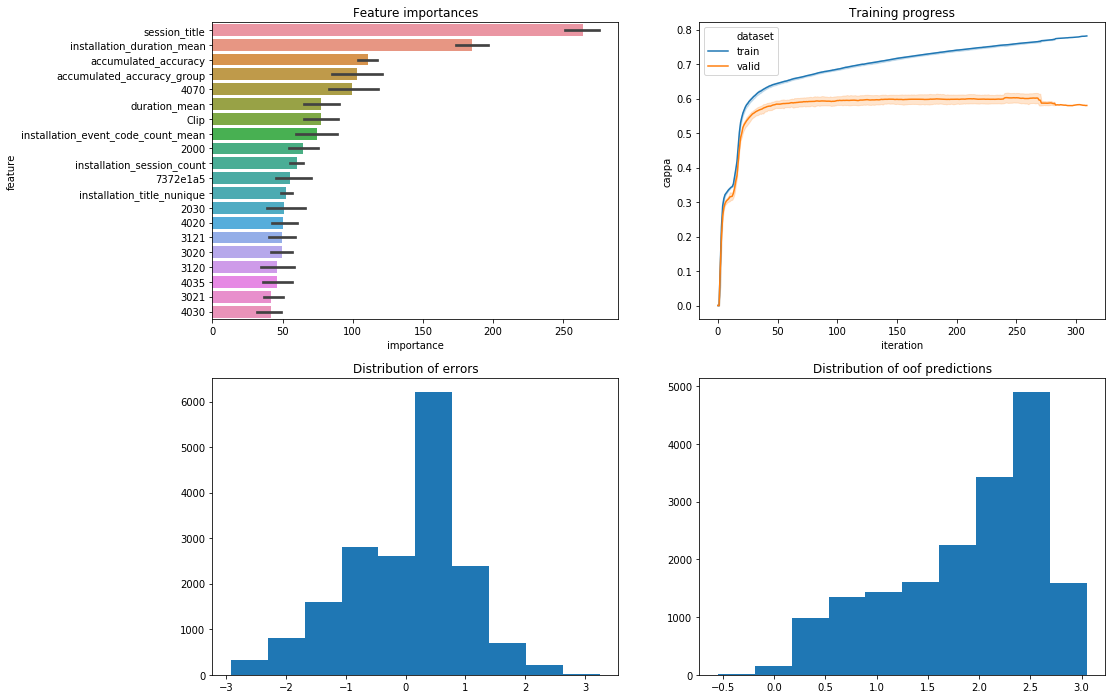

In [31]:
'''Polynomial linear models tend to work well with kappa metric, so we will begin with that'''

mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
reduce_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train.columns]
reduce_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_test.columns]
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

gc.collect()

In [39]:
fi_df = regressor_model1.feature_importances
fi_df.head()

,feature,importance
0,Activity,10
1,Assessment,22
2,Clip,64
3,Game,9
4,acc_Bird_Measurer__Assessment_,38


In [40]:
'''drop the columns with no feature importance for later model'''

remove = fe_df.loc[fe_df['importance']==0]
remove.head()

,feature,importance
24,4235,0
25,5010,0
76,1beb320a,0
90,3dfd4aa4,0
93,a1192f43,0


In [48]:
to_keep = []

for i in reduce_train.columns:
    if i not in remove['feature'].values:
        to_keep.append(i)

new_reduce_train = reduce_train[to_keep]
new_reduce_train.head()

,Activity,Assessment,Clip,Game,acc_Bird_Measurer__Assessment_,acc_Cart_Balancer__Assessment_,acc_Cauldron_Filler__Assessment_,acc_Chest_Sorter__Assessment_,acc_Mushroom_Sorter__Assessment_,2050,4100,2060,4110,2070,2075,2080,2081,2083,3110,3120,3121,4220,4230,5000,4010,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,2010,2020,4070,2025,2030,4080,2035,2040,4090,4095,d06f75b5,7d093bf9,...,Flower_Waterer__Activity_,All_Star_Sorting,Ordering_Spheres,Cart_Balancer__Assessment_,Happy_Camel,Costume_Box,Air_Show,Crystal_Caves___Level_2,Happy_Camel_3120,Cauldron_Filler__Assessment__4025,Cauldron_Filler__Assessment__4070,Sandcastle_Builder__Activity__4070,Crystal_Caves___Level_2_2000,Sandcastle_Builder__Activity__4030,All_Star_Sorting_4070,Chest_Sorter__Assessment__4030,Cauldron_Filler__Assessment__4030,Chow_Time_4070,Sandcastle_Builder__Activity__4020,Flower_Waterer__Activity__4070,Fireworks__Activity__4020,Chow_Time_3121,Cart_Balancer__Assessment__4070,Mushroom_Sorter__Assessment__4070,Tree_Top_City___Level_3_2000,All_Star_Sorting_2030,Sandcastle_Builder__Activity__4035,Chest_Sorter__Assessment__4020,Tree_Top_City___Level_1_2000,Bug_Measurer__Activity__4030,Crystal_Caves___Level_3_2000,Mushroom_Sorter__Assessment__4030,All_Star_Sorting_3010,0,1,3,installation_id,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,accumulated_accuracy_group,accumulated_actions,installation_session_count,installation_duration_mean,installation_title_nunique,sum_event_code_count,installation_event_code_count_mean
0,3,0,11,4,-1.0,-1.0,-1.0,-1.0,-1.0,6,0,0,0,0,0,4,1,2,77,7,9,0,0,0,4,92,14,31,19,121,0,79,1,0,7,9,0,18,0,20,94,4,18,0,0,6,4,0,0,0,...,166,153,1,0,0,2,0,0,0,0,0,18,0,21,42,0,0,0,7,13,23,0,0,0,0,3,0,0,1,0,0,0,12,0,0,0,0006a69f,24,0,0,0.00,0.0,3,0.0,647,5,36.99,2,647,1553.0
1,4,1,14,6,-1.0,-1.0,-1.0,-1.0,1.0,6,5,1,2,1,0,4,1,2,223,11,16,0,0,0,6,127,14,31,37,149,0,226,6,2,11,16,0,25,1,26,156,5,22,0,1,6,4,0,0,0,...,166,153,1,0,0,2,180,0,0,0,0,18,0,21,42,0,0,0,7,13,23,0,0,6,1,3,0,0,1,20,0,8,12,0,0,1,0006a69f,21,1,0,39.00,1.0,0,3.0,1143,5,36.99,2,1143,1553.0
2,4,2,14,6,0.0,-1.0,-1.0,-1.0,1.0,6,5,1,13,1,0,4,1,2,225,22,16,0,0,0,6,127,14,31,59,171,0,228,6,2,22,16,0,26,1,27,160,5,22,0,1,6,4,0,0,0,...,166,153,1,0,0,2,180,0,0,0,0,18,0,21,42,0,0,0,7,13,23,0,0,6,1,3,0,0,1,20,0,8,12,1,0,1,0006a69f,24,1,11,65.50,0.5,3,1.5,1230,5,36.99,2,1230,1553.0
3,9,4,24,10,0.0,-1.0,-1.0,-1.0,0.0,9,6,2,13,2,0,8,2,5,336,25,40,9,0,5,10,243,29,45,93,314,6,341,14,9,25,40,2,47,2,52,348,9,43,0,5,10,4,1,2,0,...,278,203,2,0,0,3,180,0,0,0,0,24,0,33,46,0,0,0,11,21,57,0,0,11,1,6,1,0,2,20,0,11,16,2,0,2,0006a69f,24,2,11,41.25,0.5,2,1.5,2159,5,36.99,2,2159,1553.0
4,10,5,28,13,0.0,-1.0,-1.0,-1.0,0.5,9,12,3,13,2,1,8,2,5,457,30,53,9,0,5,12,277,29,45,105,331,6,463,15,10,30,53,2,56,3,64,387,10,53,0,6,10,4,1,2,0,...,278,203,2,0,0,3,295,0,0,0,0,24,0,33,46,0,0,0,11,21,57,0,0,12,2,6,1,0,2,30,0,18,16,2,0,2,0006a69f,21,3,12,39.20,0.5,3,1.6,2586,5,36.99,2,2586,1553.0


In [50]:
print(new_reduce_train.shape)
print(reduce_train.shape)

(17690, 380)
(17690, 907)


In [52]:
new_reduce_train.to_csv('new_reduce_train.csv')

In [62]:
# improved
from sklearn.metrics import cohen_kappa_score
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights = 'quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [69]:
from functools import partial
import scipy as sp

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
#         Make predictions with specified thresholds
        
#         :param X: The raw predictions
#         :param coef: A list of coefficients that will be used for rounding
#         """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [70]:
pr1 = regressor_model1.predict(reduce_train)

optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), y)
coefficients = optR.coefficients()

gc.collect()

522

In [71]:
opt_preds = optR.predict(pr1.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.7110057484335771

In [72]:
pr1 = regressor_model1.predict(reduce_test)
pr1[pr1 <= 1.12232214] = 0
pr1[np.where(np.logical_and(pr1 > 1.12232214, pr1 <= 1.73925866))] = 1
pr1[np.where(np.logical_and(pr1 > 1.73925866, pr1 <= 2.22506454))] = 2
pr1[pr1 > 2.22506454] = 3

In [74]:
sample_submission = pd.read_csv('sample_submission.csv')

In [75]:
sample_submission['accuracy_group'] = pr1.astype(int)
sample_submission.to_csv('submission3.csv', index=False)

### Model 3. Updated reduced_train with feature importance greater than 0

Fold 1 started at Thu Jan 16 11:46:51 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.907911	train's cappa: 0.678159	valid's rmse: 0.977873	valid's cappa: 0.615668
[200]	train's rmse: 0.842121	train's cappa: 0.735634	valid's rmse: 0.971468	valid's cappa: 0.619614
[300]	train's rmse: 0.793427	train's cappa: 0.772836	valid's rmse: 0.969603	valid's cappa: 0.617279
Early stopping, best iteration is:
[277]	train's rmse: 0.804041	train's cappa: 0.765912	valid's rmse: 0.969887	valid's cappa: 0.622637
Fold 2 started at Thu Jan 16 11:47:27 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.906639	train's cappa: 0.678825	valid's rmse: 0.983428	valid's cappa: 0.611768
[200]	train's rmse: 0.839999	train's cappa: 0.737103	valid's rmse: 0.978291	valid's cappa: 0.613386
[300]	train's rmse: 0.791789	train's cappa: 0.773631	valid's rmse: 0.981114	valid's cappa: 0.613562
Early stopping, best iteration is:
[200]	train's rmse: 

1073

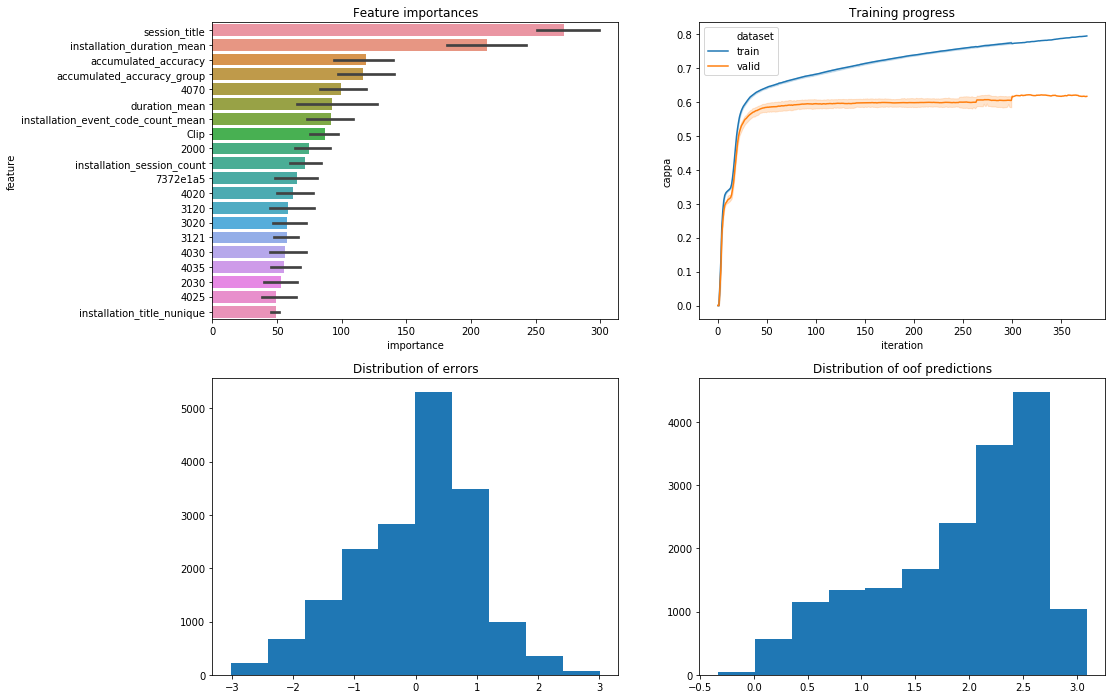

In [77]:
regressor_model2 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model2.fit(X=new_reduce_train, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

gc.collect()

In [80]:
mod2 = regressor_model2.feature_importances
train_mod2 = mod2.loc[mod2['importance']>0]
train_mod2.shape

(1835, 2)

In [86]:
to_keep2 = []

for i in reduce_train.columns:
    if i not in train_mod2['feature'].values:
        to_keep2.append(i)

train2 = reduce_train[to_keep2]
train2.head()

,4235,5010,4050,51311d7a,37db1c2f,29f54413,5859dfb6,1beb320a,756e5507,3dfd4aa4,cb1178ad,a1192f43,87d743c1,17ca3959,13f56524,b80e5e84,4901243f,99ea62f3,0086365d,ea296733,e720d930,5b49460a,3bb91dda,2b058fe3,3323d7e9,6aeafed4,cc5087a3,c6971acf,f93fc684,4b5efe37,c7f7f0e1,53c6e11a,6d90d394,736f9581,8d84fa81,d38c2fd7,c189aaf2,6f8106d9,4e5fc6f5,e7e44842,f32856e4,71e712d8,6088b756,67aa2ada,2b9272f4,30df3273,19967db1,7fd1ac25,93edfe2e,3a4be871,...,Chest_Sorter__Assessment__3110,Watering_Hole__Activity__4025,Chow_Time_3110,Chest_Sorter__Assessment__4040,Bottle_Filler__Activity__4090,Bug_Measurer__Activity__3110,Flower_Waterer__Activity__4090,Chest_Sorter__Assessment__2000,Mushroom_Sorter__Assessment__3010,Happy_Camel_4080,Leaf_Leader_3120,Bird_Measurer__Assessment__2020,Chow_Time_4090,Chow_Time_4010,Fireworks__Activity__3110,Dino_Dive_2000,Dino_Drink_2060,Leaf_Leader_4070,Dino_Dive_2070,Mushroom_Sorter__Assessment__4080,Fireworks__Activity__2000,Leaf_Leader_2075,Happy_Camel_2083,Scrub_A_Dub_2083,Dino_Drink_2070,Flower_Waterer__Activity__4030,Chow_Time_2000,Fireworks__Activity__3010,Mushroom_Sorter__Assessment__2035,Air_Show_2075,Chicken_Balancer__Activity__4080,Dino_Dive_3120,Bubble_Bath_4235,Air_Show_4100,Scrub_A_Dub_3110,Air_Show_2070,Bubble_Bath_2000,Chow_Time_4020,Chow_Time_4035,Leaf_Leader_3110,2,4,5,6,7,8,9,_999_0,installation_id,accuracy_group
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,1,0,0,2,0,50,0,15,0,0,0,0,0,0,15,0,0,0,0,0,0,4.0,5.0,6,7,8,9,-999.0,0006a69f,3
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,77,0,0,4,0,0,0,0,0,15,0,0,0,0,0,1,0,0,2,0,50,0,15,1,0,0,0,0,4,15,1,0,0,0,0,0,4.0,5.0,6,7,8,9,-999.0,0006a69f,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,2,0,1,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,77,0,0,4,0,0,1,0,0,15,0,0,0,0,0,1,0,0,2,0,50,0,15,1,0,0,0,0,4,15,1,0,0,0,0,0,4.0,5.0,6,7,8,9,-999.0,0006a69f,3
3,0,5,0,1,0,0,2,2,0,3,0,0,0,0,0,0,2,1,0,0,2,0,2,0,2,0,1,1,0,4,1,0,2,0,1,0,0,0,0,0,0,5,0,0,9,0,0,0,0,0,...,0,9,0,0,0,77,0,0,9,0,0,1,0,0,47,0,1,0,0,0,2,0,0,4,1,83,0,47,3,0,0,0,0,4,22,1,1,0,0,0,0,4.0,5.0,6,7,8,9,-999.0,0006a69f,2
4,0,5,0,1,0,0,2,2,0,4,0,0,0,0,0,0,2,1,0,0,9,0,2,0,9,0,2,1,0,4,2,0,2,0,1,0,0,0,0,0,0,5,0,0,9,0,0,0,0,0,...,0,9,0,0,0,121,0,0,12,0,0,1,0,0,47,0,1,0,0,0,2,0,0,4,1,83,0,47,4,1,0,0,0,8,22,1,1,0,0,0,1,4.0,5.0,6,7,8,9,-999.0,0006a69f,3


In [ ]:
# cols = [col for col in reduce_test.columns if col in train2.columns]
# test2 = reduce_test[cols]

In [91]:
cols = [col for col in reduce_test.columns if col in new_reduce_train.columns]
new_reduce_test = reduce_test[cols]

In [92]:
pr2 = regressor_model2.predict(new_reduce_train)

optR = OptimizedRounder()
optR.fit(pr2.reshape(-1,), y)
coefficients = optR.coefficients()

gc.collect()

13776

In [93]:
opt_preds = optR.predict(pr2.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.6905926433518186

In [95]:
pr2 = regressor_model2.predict(new_reduce_test)
pr2[pr2 <= 1.12232214] = 0
pr2[np.where(np.logical_and(pr2 > 1.12232214, pr2 <= 1.73925866))] = 1
pr2[np.where(np.logical_and(pr2 > 1.73925866, pr2 <= 2.22506454))] = 2
pr2[pr2 > 2.22506454] = 3

In [98]:
sample_submission['accuracy_group'] = pr2.astype(int)
sample_submission.to_csv('submission4.csv', index=False)

### Model 3. sub-500 features

Fold 1 started at Thu Jan 16 12:52:34 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.06518	train's cappa: 0.502736	valid's rmse: 1.15495	valid's cappa: 0.33711
[200]	train's rmse: 1.00694	train's cappa: 0.580239	valid's rmse: 1.14863	valid's cappa: 0.382066
[300]	train's rmse: 0.96656	train's cappa: 0.627784	valid's rmse: 1.14934	valid's cappa: 0.381404
Early stopping, best iteration is:
[205]	train's rmse: 1.00462	train's cappa: 0.582447	valid's rmse: 1.14792	valid's cappa: 0.383009
Fold 2 started at Thu Jan 16 12:53:03 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 1.06306	train's cappa: 0.503173	valid's rmse: 1.16224	valid's cappa: 0.339555
[200]	train's rmse: 1.00557	train's cappa: 0.580883	valid's rmse: 1.15889	valid's cappa: 0.353561
Early stopping, best iteration is:
[179]	train's rmse: 1.01607	train's cappa: 0.565485	valid's rmse: 1.15819	valid's cappa: 0.358562
Fold 3 started at Thu Jan 16 12:53:

1073

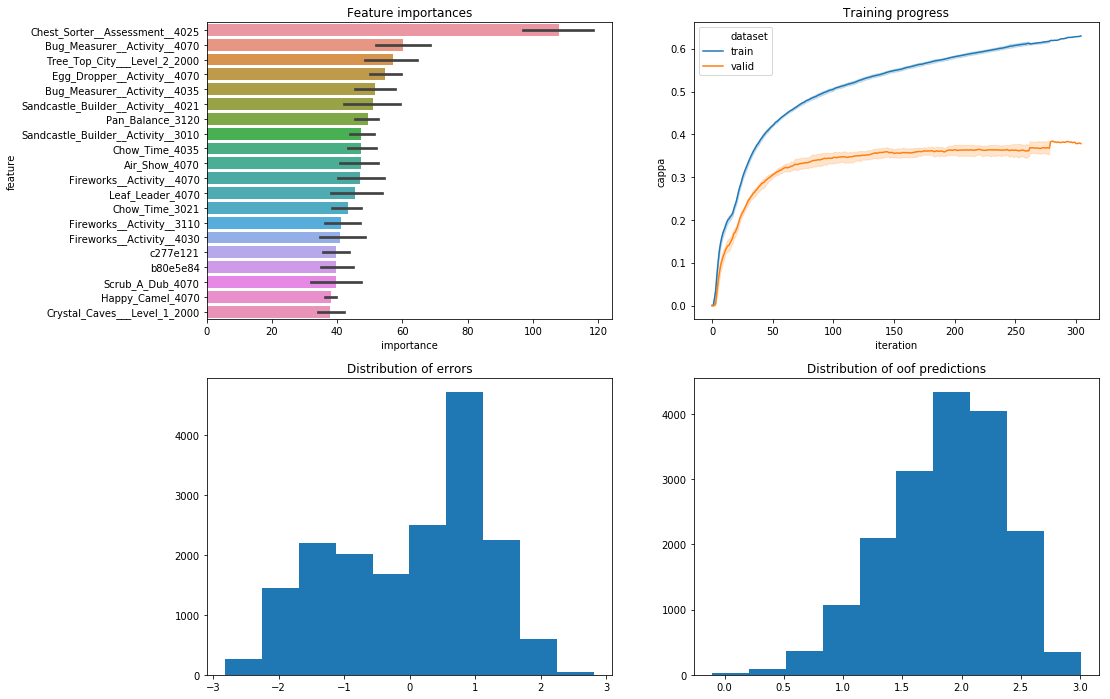

In [99]:
regressor_model3 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model3.fit(X=train2, y=y, folds=folds, params=params, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)

gc.collect()

In [100]:
pr3 = regressor_model3.predict(train2)

optR = OptimizedRounder()
optR.fit(pr3.reshape(-1,), y)
coefficients = optR.coefficients()

gc.collect()

13501

In [101]:
opt_preds = optR.predict(pr3.reshape(-1, ), coefficients)
qwk(y, opt_preds)

0.5048789656554065

In [102]:
pr3 = regressor_model3.predict(test2)
pr3[pr3 <= 1.12232214] = 0
pr3[np.where(np.logical_and(pr3 > 1.12232214, pr3 <= 1.73925866))] = 1
pr3[np.where(np.logical_and(pr3 > 1.73925866, pr3 <= 2.22506454))] = 2
pr3[pr3 > 2.22506454] = 3

In [103]:
sample_submission['accuracy_group'] = pr3.astype(int)
sample_submission.to_csv('submission5.csv', index=False)

In [104]:
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,1
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,2
